# 教程 3：单资产 HANK 模型

在本笔记本中，我们求解 Auclert, Bardóczy, Rognlie, Straub (2021) 的单资产 HANK 模型：“使用序列空间雅可比矩阵求解和估计异质性代理模型”（[论文链接](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)）。

新概念：
- **异质性输入（Hetinputs）和异质性输出（Hetoutputs）**：将现成的异质性代理模块（HA blocks）适应于新的宏观经济模型。
- **校准有向无环图（Calibration DAG）**：利用内部校准的解析部分。

有关 SSJ 工具包的更多示例和信息，请访问我们的 [GitHub 页面](https://github.com/shade-econ/sequence-jacobian)。

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, create_model  # functions
from sequence_jacobian import hetblocks, grids      # modules

## 1 模型描述

该模型是教科书式新凯恩斯模型的异质性代理版本。技术与劳动呈线性关系，价格具有 Rotemberg 风格的粘性，货币政策遵循泰勒规则。模型可以用序列形式总结如下：

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s \})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

其中，内生变量为 $\textbf{X} = (Y, L, r, w, d, \pi, \tau, i)$，外生变量为 $\textbf{Z}=(r^*, Z)$。

资产需求和劳动供给函数 $\{\mathcal{A}, \mathcal{L}\}$ 由家庭模块的贝尔曼方程推导而来：

$$
\begin{align} \tag{HH}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \mathbb{E}_t\left[V_{t+1}(e', a)|e \right] \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

其中，$\bar\tau(e)$ 和 $\bar d(e)$ 分别是针对税收和股息的技能特定分配规则。

我们可以将该模型视为一个有 **3 个内生输入** 的有向无环图（DAG），并将其表示为隐函数：

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

## 2 Embed HA block

正如我们在克鲁塞尔-史密斯笔记本中所见，设置异质性代理（HA）模块的主要任务是编写一个后向迭代函数，以表示贝尔曼方程。这必须是诸如价值函数迭代等迭代解法的单步操作。对于我们这里处理的标准收入波动问题以及内生劳动供给问题，[卡罗尔（2006年）](https://www.sciencedirect.com/science/article/pii/S0165176505003368)的内生网格点方法是最佳实践。

通过内生网格点法（EGM）解决内生劳动问题是很常见的，但过程较为繁琐，因此具体细节被留到了 `sequence_jacobian/hetblocks/hh_labor.py` 中。相反，我们将重点介绍如何将这个现成的异质性模块适应于我们特定的宏观环境。

In [25]:
hh = hetblocks.hh_labor.hh

print(hh)
print(f'Inputs: {hh.inputs}')
print(f'Macro outputs: {hh.outputs}')
print(f'Micro outputs: {hh.internals}')

<HetBlock 'hh'>
Inputs: ['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'n']


异质性模块 `hh` 对应于一般性问题：

$$
\begin{align} \tag{HH-general}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \mathbb{E}_t\left[V_{t+1}(e', a)|e\right] \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t(e) n + T_t(e)
\\
a &\geq 0
\end{align}
$$

也就是说，家庭将利率序列 $r_t$、技能特定的工资 $w_t(e)$ 和转移支付 $T_t(e)$ 视为既定的。在这一特定的 HANK 模型中，转移支付等于股息减去税收。但很容易想象其他许多情况。我们无需为每种情况编写特定的后向迭代函数，只需提供一个函数来指定在特定情况下如何确定 $\{w_t(e), T_t(e)\}$。我们称这类函数为 **hetinput**。

此外，我们需要报告有效的劳动供给 $ne = n\cdot e$，以解决劳动市场的出清问题。我们可以通过将一个 **hetoutput** 函数附加到核心异质性模块上来实现这一点。

### 2.1 Hetinputs

让我们从 **hetinputs** 开始。这些函数将在核心异质性模块（即后向迭代）之前进行评估。

In [26]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    """
    Generate the income and asset grids.

    Uses the Rouwenhorst method to construct the Markov grid for income shocks 
    and creates an asset grid using the provided parameters.

    Parameters:
        rho_e (float): Persistence parameter for the income Markov process.
        sd_e (float): Standard deviation of the income shocks.
        nE (int): Number of states in the income grid.
        amin (float): Minimum asset level.
        amax (float): Maximum asset level.
        nA (int): Number of points in the asset grid.
    
    Returns:
        tuple: A tuple containing:
            - e_grid (array-like): The income/skill grid.
            - pi_e (array-like): Probabilities for the income grid states.
            - Pi (array-like): Transition probability matrix for the Markov process.
            - a_grid (array-like): The asset grid.
    """
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid


def transfers(pi_e, Div, Tax, e_grid):
    """
    Calculate net transfers based on dividends and taxes with incidence rules.

    Dividends and taxes are allocated proportionally to skill as represented by 
    the income grid. The function scales these flows so that the aggregate values 
    match Div and Tax, respectively.

    Parameters:
        pi_e (array-like): Probability weights for each income state.
        Div (float): Total dividend value.
        Tax (float): Total tax value.
        e_grid (array-like): Income/skill grid used to determine the incidence.
    
    Returns:
        array-like: Net transfers for each income state (dividends minus taxes).
    """
    # Hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T


def wages(w, e_grid):
    """
    Compute skill-adjusted wages.

    Multiplies the base wage rate by the income/skill grid to yield wages 
    that vary with skill level.

    Parameters:
        w (float): Base wage rate.
        e_grid (array-like): Income/skill grid.
    
    Returns:
        array-like: The computed wages adjusted by skill.
    """
    we = w * e_grid
    return we

- 第二个 **hetinput** 函数 `transfers` 接收由第一个 **hetinput** 函数 `make_grid` 生成的输入（`e_grid` 和 `pi_e`）。这种 **非循环** 的依赖关系是被允许的。模块会处理 **hetinput** 函数的输入和输出，并将它们按照正确的评估顺序排列。

- **hetinput** 的标量输入值可以是时变的。例如，在 HANK 模型中，总股息和税收（`Div` 和 `Tax`）是内生决定的，并通过 **hetinput** 函数 `transfers` 传递到贝尔曼方程中。因此，我们可以计算它们的雅可比矩阵。

让我们使用（恰如其名的）`HetBlock.add_hetinput` 方法将这些 **hetinputs** 添加到家庭模块中。

In [27]:
hh1 = hh.add_hetinputs([make_grid, transfers, wages])

print(hh1)
print(f'Inputs: {hh1.inputs}')

<HetBlock 'hh' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Tax', 'w']


Note that `hh1` has only scalar-valued inputs.

### 2.2 Hetoutputs

**Hetoutput** 函数与 **hetinput** 函数类似。它们在后向迭代收敛之后被调用。因此，它们可以接受后向迭代函数的多维输出以及 **hetinput** 的输出作为输入。

In [28]:
def labor_supply(n, e_grid):
    """
    Compute effective labor supply adjusted for efficiency levels.

    This function calculates the effective labor supply by multiplying the labor input
    with a grid of efficiency (or skill) levels. The efficiency grid is reshaped to a
    column vector to allow broadcasting when performing the multiplication with n.

    Parameters:
        n (array-like): Labor supply input (scalar or vector).
        e_grid (array-like): One-dimensional array representing efficiency or skill levels.

    Returns:
        array-like: The effective labor supply computed as the product of n and the efficiency grid.
    """
    ne = e_grid[:, np.newaxis] * n
    return ne

让我们使用 `HetBlock.add_hetoutput` 方法将这个 **hetoutput** 添加到家庭模块中。

In [29]:
hh_ext = hh1.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')

<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']


- **HetBlock** 的签名 `hh_ext` 现在同时引用了 **hetinputs** 和 **hetoutputs**。
- 总量输出现在包括了有效劳动供给 `NE`。

### 2.3 总结

SSJ 工具包提供了 3 个通用的 **HetBlock**，位于 `sequence_jacobian/hetblocks`。
- `hh_sim`：标准的不完全市场模型
- `hh_labor`：带有无摩擦劳动供给的标准不完全市场模型
- `hh_twoasset`：带有凸性投资组合调整成本的两资产模型

通过使用 **hetinputs** 和 **hetoutputs**，这些核心模块可以嵌入到不同的宏观环境中。这是使用 SSJ 工具包的最简单方式，对于许多应用来说可能已经足够。

如果你希望解决的模型不仅仅是这些现成 **HetBlock** 的变体，那么需要考虑两种情况：
1. 模型符合 **HetBlock** 的范式。例如，带有额外选择（如搜索强度）的标准不完全市场模型。你只需要编写一个新的后向迭代函数，用它来实例化一个新的 **HetBlock**，并免费获得所有 **HetBlock** 的方法。
2. 模型不符合 **HetBlock** 的范式。例如，具有离散内生状态的模型。在这种情况下，我们建议你“自行求解雅可比矩阵”。也就是说，在 SSJ 工具包之外求解你的模块的雅可比矩阵。一旦你将其转换为 `JacobianDict` 的实例（就像我们在克鲁塞尔-史密斯笔记本的第 4 节中所做的那样），就可以将其作为实际模块的替代品纳入宏观模型中。这足以在宏观模型层面使用线性解法（`impulse_linear`、`jacobian` 及其 `solved_` 版本）。

## 3 稳态校准

与 RBC 示例类似，我们校准贴现因子 $\beta$ 和劳动的负效用 $\varphi$，以达到目标利率和有效劳动 $L=1$。此外，我们还校准工资 $w$，以确保在零通胀 $\pi=0$ 的情况下，菲利普斯曲线关系在稳态中成立。

需要注意的是，从 $\beta$ 到给定 $r$ 的资产市场出清的映射，以及从 $\varphi$ 到平均有效劳动供给的映射，都涉及家庭模块。因此，我们必须依赖数值求根方法。相比之下，$w$ 可以从 NKPC 的稳态版本中很容易地解析地表示为：
$$
w = \frac{Z}{\mu} \tag{稳态工资}
$$

这种情况在 HA-DSGE 模型中非常常见。尽管在简单模型中，对所有未知数同时使用数值求根器可能成功，但在更复杂的模型中，利用解析解变得至关重要。

实现这一点的最简单方法是使用两个有向无环图（DAG）：一个用于校准，另一个用于过渡动态。通常，这两个 DAG 会共享一些模块，但并非全部。此外，它们可能有不同的未知数和目标。

### 3.1 稳态 DAG 的模块

我们已经实现了家庭模块。接下来，我们定义其余模块为简单模块。

In [30]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    """
    Calculate labor input and firm dividends.

    Parameters:
    Y (numeric): Total output produced by the firm.
    w (numeric): Wage rate.
    Z (numeric): Productivity factor.
    pi (object): Inflation factor, expected to support .apply(np.log) for logarithm computation.
    mu (numeric): Markup parameter.
    kappa (numeric): Adjustment cost parameter.

    Returns:
    tuple: A tuple (L, Div) where:
        L is the labor input computed as Y / Z,
        Div is the dividends computed as the residual after paying wages and inflation adjustment costs.
    """
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    """
    Compute the nominal interest rate based on the monetary policy rule.

    Parameters:
    pi (callable): Current inflation factor; supports lag operator when called (e.g., pi(-1)).
    rstar (callable): Natural rate of interest; supports lag operator when called (e.g., rstar(-1)).
    phi (numeric): Coefficient that scales lagged inflation in the policy rule.

    Returns:
    numeric: The computed nominal interest rate.
    """
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B):
    """
    Calculate tax revenue from interest payments on bonds.

    Parameters:
    r (numeric): The interest rate.
    B (numeric): The stock of bonds.

    Returns:
    numeric: Tax revenue computed as the product of the interest rate and bond holdings.
    """
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    """
    Determine the market clearing imbalances in the asset, labor, and goods markets.

    Parameters:
    A (numeric): Total asset supply.
    NE (numeric): Effective labor supply.
    C (numeric): Consumption.
    L (numeric): Labor demand.
    Y (numeric): Total output.
    B (numeric): Bond holdings.
    pi (object): Inflation factor; expected to support .apply(np.log) for logarithm computation.
    mu (numeric): Markup parameter.
    kappa (numeric): Adjustment cost parameter.

    Returns:
    tuple: A triple (asset_mkt, labor_mkt, goods_mkt) where:
        asset_mkt is the asset market imbalance (A - B),
        labor_mkt is the labor market imbalance (NE - L),
        goods_mkt is the goods market imbalance accounting for consumption and inflation adjustment costs.
    """
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    """
    Compute the steady-state wage as derived from the New Keynesian Phillips Curve.

    Parameters:
    Z (numeric): Productivity factor.
    mu (numeric): Markup parameter.

    Returns:
    numeric: The steady-state wage computed as Z divided by mu.
    """
    w = Z / mu
    return w

- 除了 `nkpc_ss` 外，这些模块在过渡动态和稳态中都是有效的。
- 注意，我们在简单模块中用 `.apply()` 包裹了 `np.log()`。这是必要的，因为对于名称中包含点（`.`）的函数，它会干扰简单模块内部处理前导项、滞后项以及对稳态引用的一些操作。

In [31]:
blocks_ss = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi', 'B']


Print inputs so we don't have to remember everything.

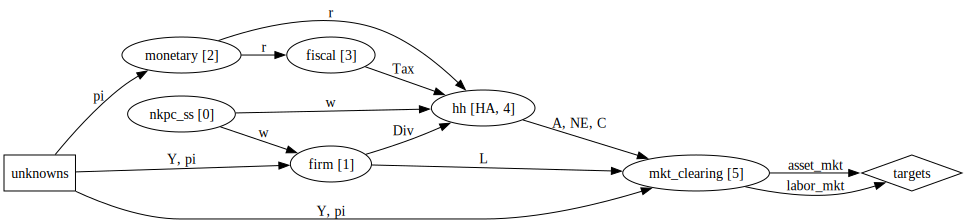

In [32]:
from sequence_jacobian import drawdag
unknowns = ['Y','pi']
targets = ['asset_mkt','labor_mkt']
drawdag(hank_ss,unknowns=unknowns,targets=targets,leftright=True)

In [33]:
calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 3,
               'amin': 0.0, 'amax': 150, 'nA': 100, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5,'B': 5.6,}

unknowns_ss = {'beta': 0.986,'vphi': 0.8,}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

Let's see the targets and Walras's law.

In [34]:
print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  4.35e-14
Labor market clearing:  8.88e-16
Goods market clearing (untargeted): -2.81e-09


Looks good. Let's also plot the labor supply policy as function of assets for each skill type. We see that poorer and more productive households choose to work more. 


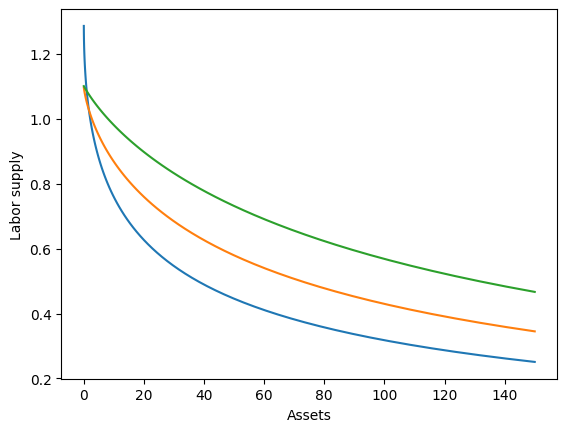

In [35]:
plt.plot(ss0.internals['hh']['a_grid'], ss0.internals['hh']['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

## 4 使用雅可比矩阵的线性化动态

回想一下，我们将模型简化为一个隐式方程
$$
H(\pi, Y, w; r^*, Z) =
\begin{pmatrix}
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{L}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0\end{pmatrix},
$$

以求解 $U=(\pi, w, Y)$，给定任何 $Z=(Z, r^*)$。其余的内生变量可以沿着 DAG 作为 $(\pi, w, Y; Z, r^*)$ 的显式函数获得，但写出它们会很繁琐。

记住，隐式函数定理意味着未知数的响应是

$$
dU = \underbrace{-H_U^{-1}H_Z}_{G_U} dZ \tag{1}
$$

回想一下，我们已经求解了稳态并将其存储为 `ss`。此外，我们将使用 300 期的截断地平线。

### 4.1 设置 DAG

让我们设置第二个（主要的）DAG。我们只需要将 `nkpc_ss` 替换为完整的菲利普斯曲线。

In [36]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    """
    Compute the residual for the New Keynesian Phillips Curve (NKPC).

    This function evaluates the NKPC residual given the current and forward-looking
    values of inflation, output, wages, and other economic parameters. The formula
    incorporates the adjustment for markups and the intertemporal tradeoffs implied 
    by forward-looking behavior.

    Parameters:
    -----------
    pi : callable
        Function or series representing the inflation rate. Supports time-forward 
        indexing using the call operator (e.g., pi(+1)).
    w : callable
        Function or series representing the wage rate.
    Z : callable
        Function or series representing the productivity shock.
    Y : callable
        Function or series representing the output.
    r : callable
        Function or series representing the interest rate.
    mu : float
        The markup parameter.
    kappa : float
        The sensitivity parameter affecting the response of inflation to wage variations.

    Returns:
    --------
    nkpc_res : numeric or array-like
        The computed residual of the NKPC equation.
    """
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1)) \
               - (1 + pi).apply(np.log)
    return nkpc_res


# Define the model blocks and create the HANK model using them.
blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

print(*hank.blocks, sep='\n')

<SimpleBlock 'monetary'>
<SimpleBlock 'nkpc'>
<SimpleBlock 'fiscal'>
<SimpleBlock 'firm'>
<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
<SimpleBlock 'mkt_clearing'>


- 回想一下，`create_model` 会执行拓扑排序，以将模块按（不一定唯一）正确的评估顺序排列。在这里，`monetary` 必须排在第一位，然后是 `nkpc`、`fiscal` 和 `firm`（顺序任意），接着是 `hh`，最后是 `mkt_clearing`。注意，`hank.blocks` 是按这种顺序排列的模块列表。

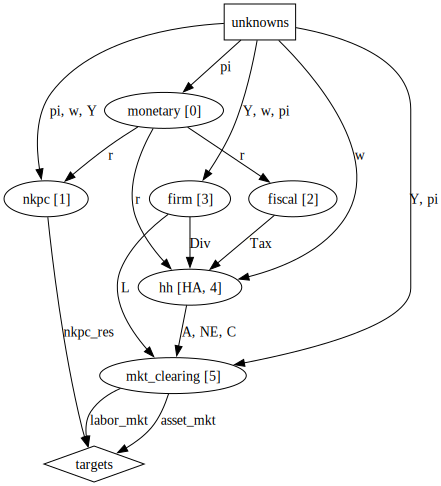

In [37]:
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

drawdag(hank,unknowns=unknowns,targets=targets,leftright=False)

在继续之前，让我们确保 `ss0` 与第二个 DAG 一致。只需在 `ss0` 处评估 `hank`，并验证均衡条件是否如预期那样成立。

In [38]:
calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 3,
               'amin': 0.0, 'amax': 150, 'nA': 100, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005,'B': 5.6,'phi': 1.5}

unknowns_ss = {'beta': 0.986,'vphi': 0.8,'w':0.833}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0,'nkpc_res':0}


ss = hank.solve_steady_state(calibration,unknowns_ss,targets_ss,solver="hybr")

for k in ss0.keys():
    if not np.all(np.isclose(ss[k], ss0[k])):
        print(f"Mismatch found for {k}:")
        print(f"ss[{k}] = {ss[k]}")
        print(f"ss0[{k}] = {ss0[k]}")

### 4.2 获取一般均衡雅可比矩阵

有了模型对象 `hank`，我们可以通过其 `solve_jacobian` 方法获得一般均衡的雅可比矩阵。

In [39]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'Tax', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Z']>


在幕后，`solve_jacobian` 方法执行以下步骤：
- 计算所有模块的偏雅可比矩阵 $\mathcal{J}^{o,i}$（如果它们的雅可比矩阵尚未提供），仅针对实际变化的输入：未知数、外生冲击、前面模块的输出。
- 向前累积偏雅可比矩阵 $\mathcal{J}^{o,i}$ 以形成总雅可比矩阵 $\mathbf{J}^{o,i}$。
- 将 $\mathbf{J}^{o,i}$ 打包以形成 $\mathbf{H_U}$ 和 $\mathbf{H_Z}$。
- 求解一般均衡雅可比矩阵 $\mathbf{G_U} = \mathbf{H_U}^{-1}\mathbf{H_Z}$。
- 向前累积一般均衡雅可比矩阵以获得其他内生变量的 $\mathbf{G}$。

### 4.3 结果

现在，让我们考虑不同持续性的 25 个基点的货币政策冲击，并绘制通胀的响应。

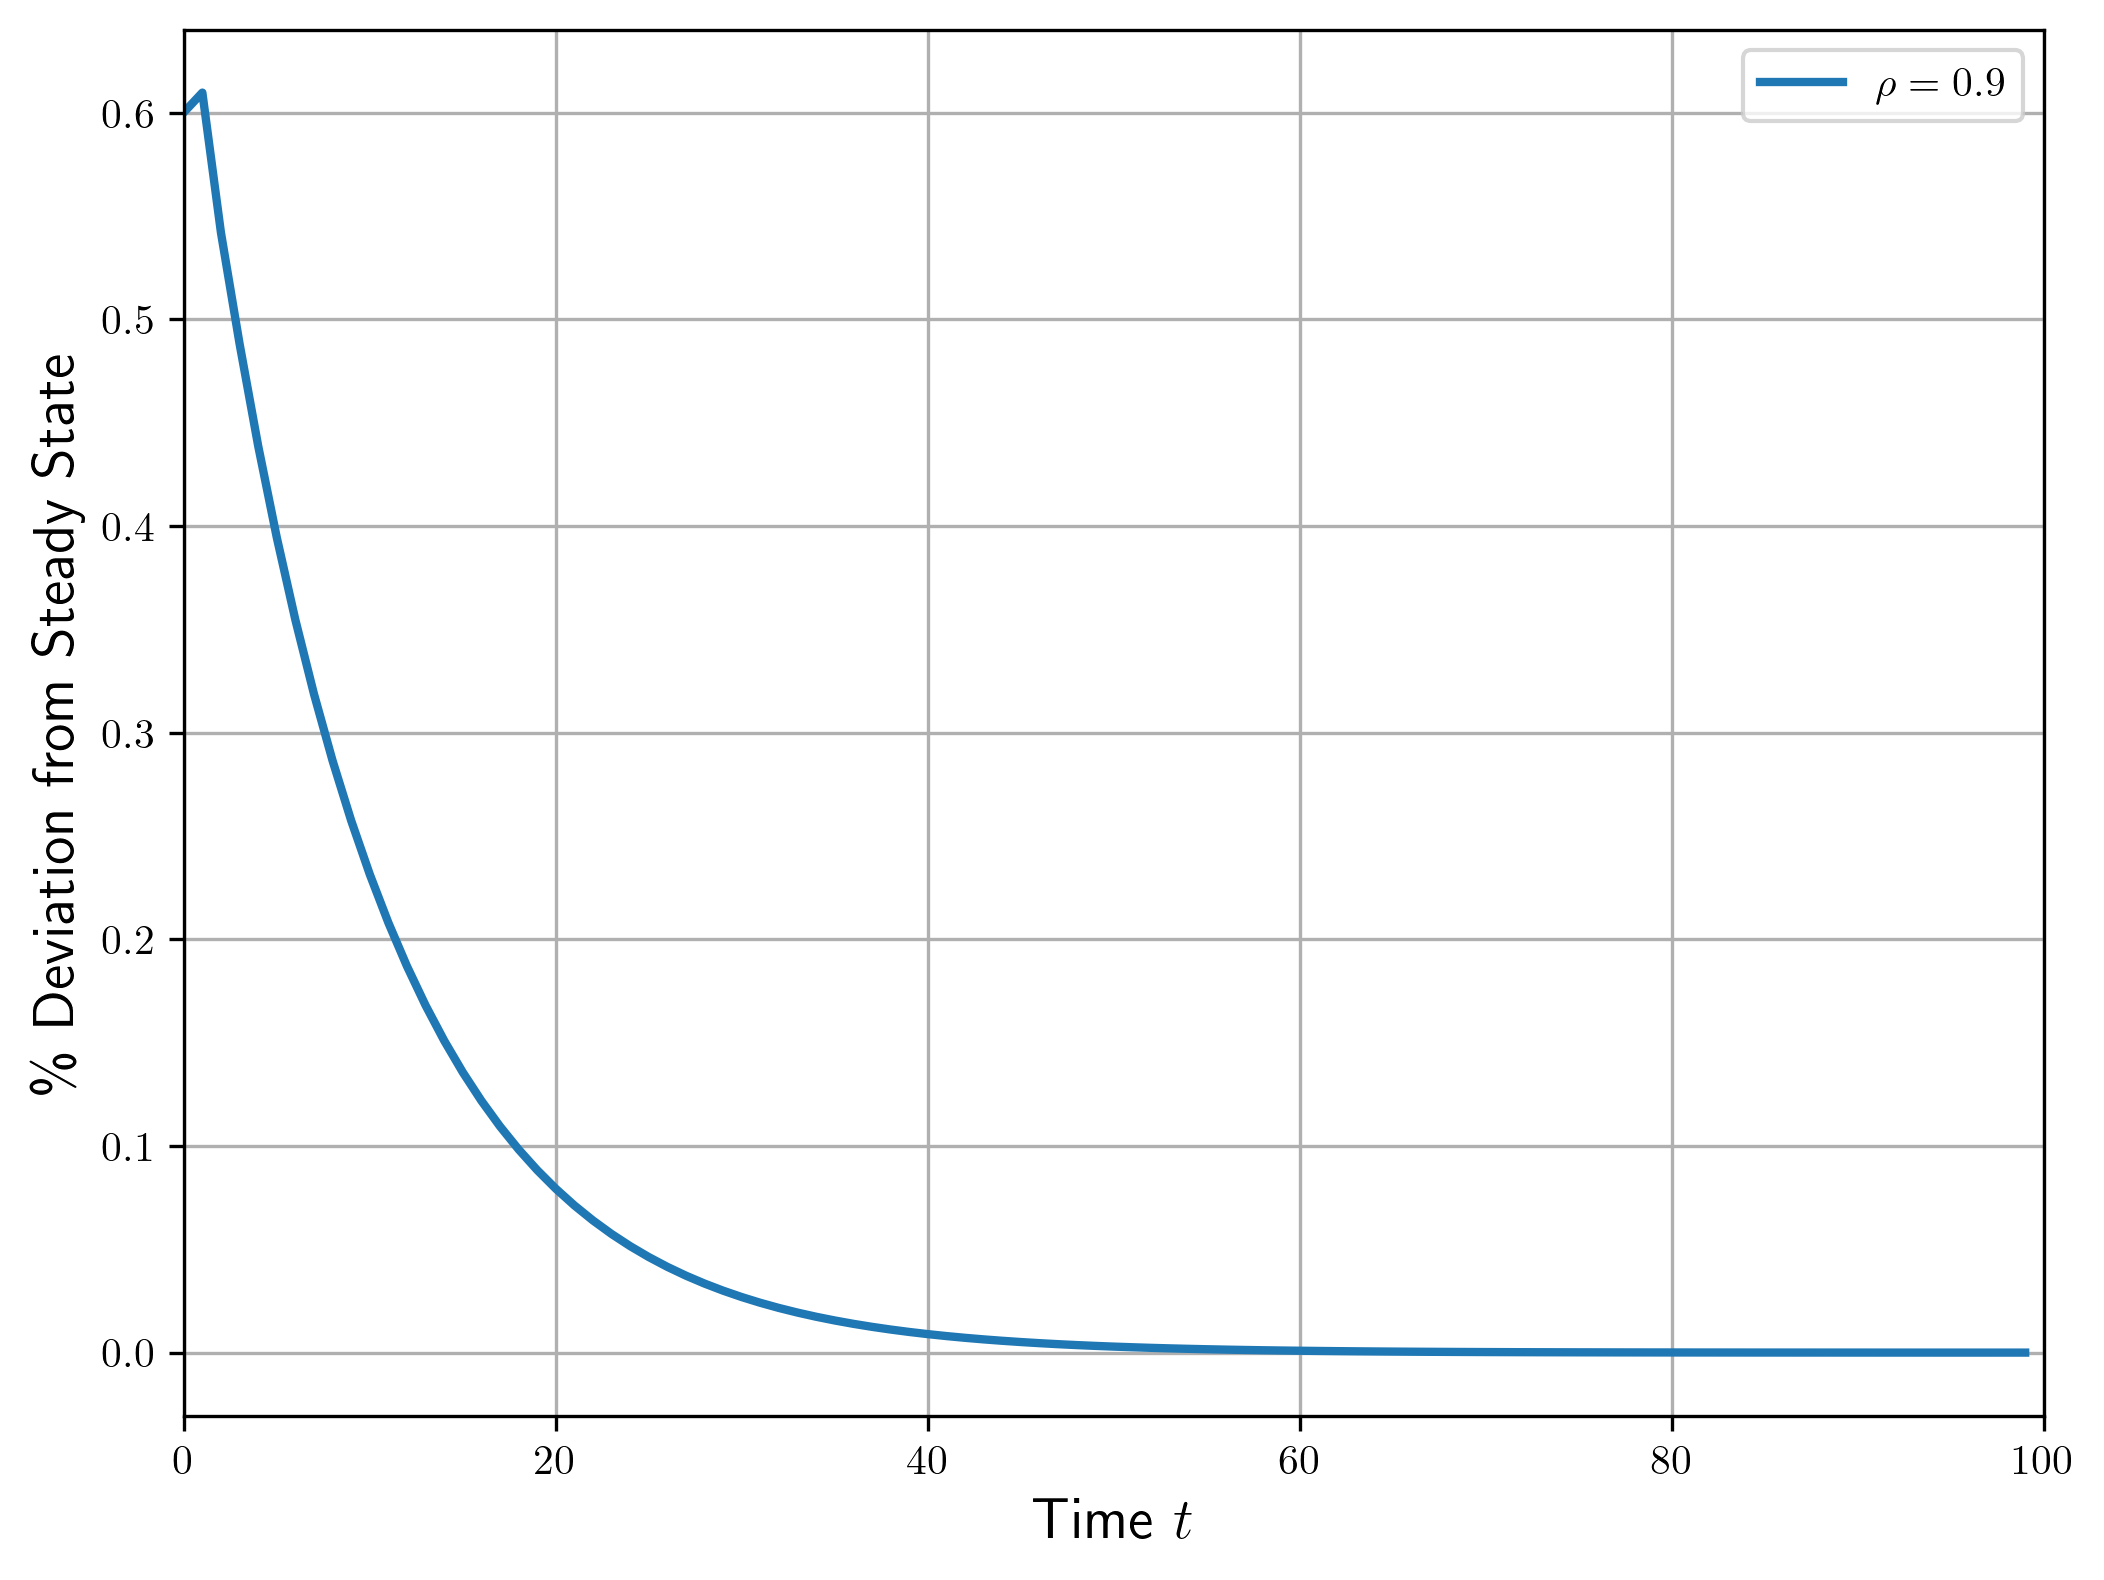

In [43]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True  # Enable LaTeX rendering for all text in plots

# Define an array of persistence parameters for the shocks to $Z$.
rhos = np.array([0.9,])

# Generate a matrix of shock paths ($dZ$) for each persistence parameter.
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis])
dY = G['Y']['Z'] @ dZ
# Create an enhanced plot with increased figure size, resolution, markers, grid, and a legend for better clarity.
plt.figure(figsize=(8, 6), dpi=300)
for i, rho in enumerate(rhos):
    plt.plot(100 *dY[:100, i], lw=2, markersize=4, label=f'$\\rho = {rho}$')
plt.xlim(0,100)
plt.ylabel(r'\% Deviation from Steady State', fontsize=14)
plt.xlabel(r'Time $t$', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

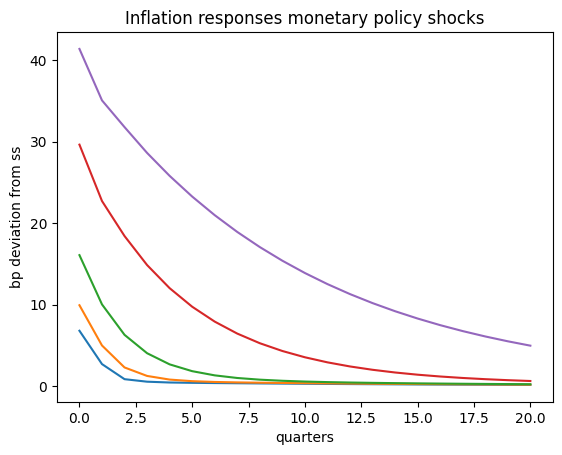

In [40]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar

plt.plot(10000 * dpi[:21])
plt.title(r'Inflation responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

## 5. 非线性动态

与 Krusell-Smith 笔记本相比，这一节在概念上没有新内容。我们将实现一个拟牛顿算法，以求解给定某些冲击序列 $(r^*, Z)$ 下的未知序列 $U=(\pi, w, Y)$。我们通过假设 $U$ 中的变量保持在其稳态水平不变来初始化算法。然后，我们评估 DAG 并使用逆雅可比矩阵 $H_U^{-1}$ 更新猜测。尽管存在显著的非线性，该算法仅需几步即可收敛。

### 5.1 典型的货币政策冲击

注意，线性化解忽略了价格调整成本。对于典型大小和持续性的货币政策冲击，这并不重要。

Solving One-Asset HANK for ['pi', 'w', 'Y'] to hit ['nkpc_res', 'asset_mkt', 'labor_mkt']
On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.42E-02
   max error for labor_mkt is 2.80E-03
On iteration 1
   max error for nkpc_res is 1.18E-06
   max error for asset_mkt is 1.29E-04
   max error for labor_mkt is 4.85E-06
On iteration 2
   max error for nkpc_res is 2.54E-08
   max error for asset_mkt is 2.23E-06
   max error for labor_mkt is 1.43E-07
On iteration 3
   max error for nkpc_res is 8.75E-10
   max error for asset_mkt is 3.78E-08
   max error for labor_mkt is 2.59E-09
On iteration 4
   max error for nkpc_res is 1.69E-11
   max error for asset_mkt is 5.90E-10
   max error for labor_mkt is 4.81E-11


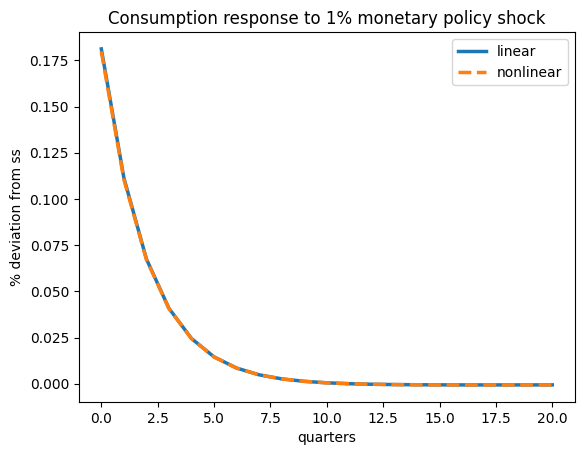

In [41]:
rho_r, sig_r = 0.61, -0.01/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path)
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path)

dC_nonlin = 100 * td_nonlin['C']
dC_lin = 100 * td_lin['C']

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

### 5.2 非常大的货币政策冲击

然而，对于非常大或持续性很强的货币政策冲击，非线性可能会变得显著。令人欣慰的是，雅可比矩阵仍然可以很好地作为更新规则。对于一个 10% 的货币政策冲击（极其大！），拟牛顿方法仍然在仅 9 次迭代后收敛，尽管结果中明显存在非线性。

Solving One-Asset HANK for ['pi', 'w', 'Y'] to hit ['nkpc_res', 'asset_mkt', 'labor_mkt']
On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.38E-01
   max error for labor_mkt is 2.77E-02
On iteration 1
   max error for nkpc_res is 1.05E-04
   max error for asset_mkt is 1.27E-02
   max error for labor_mkt is 3.33E-04
On iteration 2
   max error for nkpc_res is 3.29E-05
   max error for asset_mkt is 2.26E-03
   max error for labor_mkt is 4.75E-04
On iteration 3
   max error for nkpc_res is 3.61E-06
   max error for asset_mkt is 4.15E-04
   max error for labor_mkt is 6.18E-05
On iteration 4
   max error for nkpc_res is 1.25E-06
   max error for asset_mkt is 7.59E-05
   max error for labor_mkt is 1.31E-05
On iteration 5
   max error for nkpc_res is 1.99E-07
   max error for asset_mkt is 1.37E-05
   max error for labor_mkt is 2.15E-06
On iteration 6
   max error for nkpc_res is 4.02E-08
   max error for asset_mkt is 2.45E-06
   max error for labor_mkt is 4.

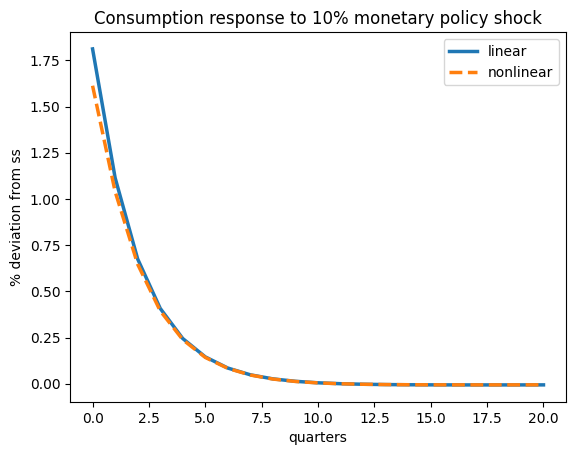

In [42]:
rho_r, sig_r = 0.61, -0.10/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path)
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path)

dC_nonlin = 100 * td_nonlin['C']
dC_lin = 100 * td_lin['C']

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 10% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()